In [1]:
import numpy as np
import sklearn
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('figure', figsize=[10,5])
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_curve, precision_score, accuracy_score, average_precision_score, recall_score, f1_score, classification_report, confusion_matrix
from util import evaluate_data, graph_LC, graph_C, normalize_data, create_stratified_data, prepare_data, preprocess_ufc_data

DecisionTreeClassifier(ccp_alpha=0.003, criterion='entropy')
0.9340335912962149
0.9070708382857677


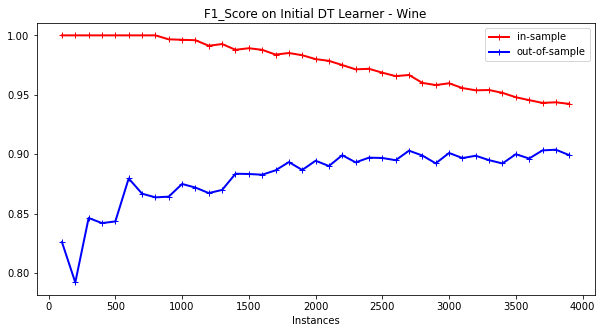

DecisionTreeClassifier(ccp_alpha=0.001, max_depth=6) 0.9100913325741125


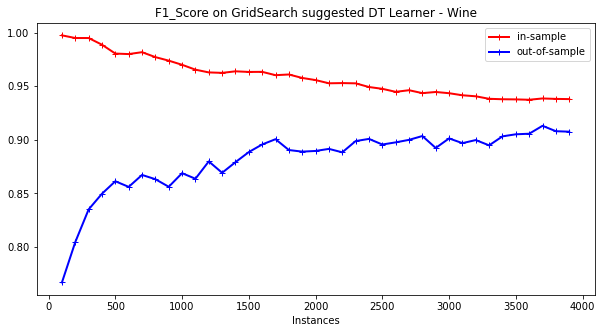

DecisionTreeClassifier(ccp_alpha=0.0014, max_depth=10) 0.9140469812411578


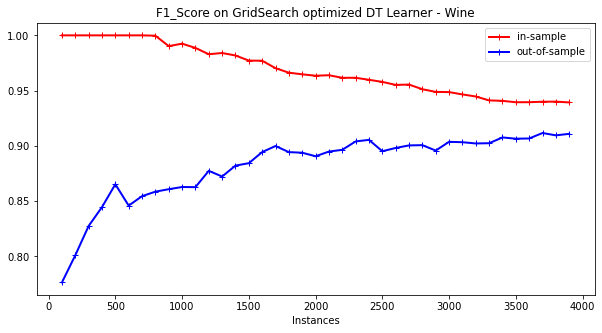

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.8s finished


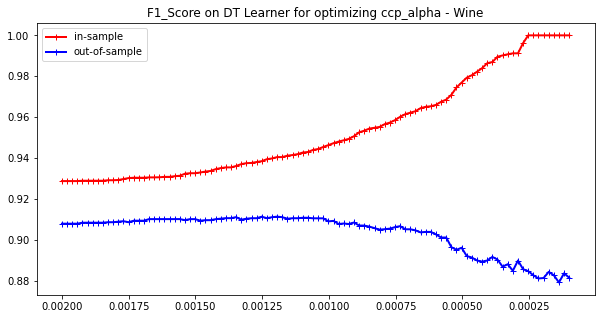

0.0011939393939393939


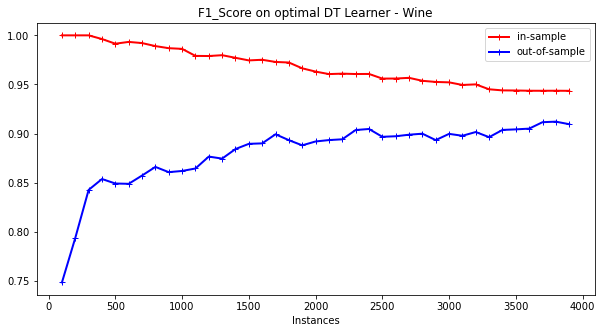

              precision    recall  f1-score   support

           1    0.91139   0.91429   0.91284       315
           2    0.92268   0.88834   0.90518       403
           3    0.86824   0.91135   0.88927       282

    accuracy                        0.90300      1000
   macro avg    0.90077   0.90466   0.90243      1000
weighted avg    0.90377   0.90300   0.90311      1000

0.9031075429636443
DecisionTreeClassifier(ccp_alpha=0.005, criterion='entropy')
DecisionTreeClassifier(ccp_alpha=0.005, criterion='entropy')
0.6202125553226182
[0.54030677 0.59503722 0.54740702 0.58764368 0.56540478 0.57327868
 0.58208657 0.64537356 0.61199106 0.58359242] 0.583212175499183


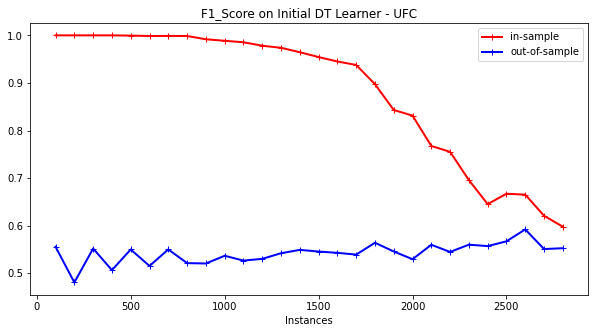

DecisionTreeClassifier(ccp_alpha=0.005, criterion='entropy', max_depth=7) 0.583212175499183


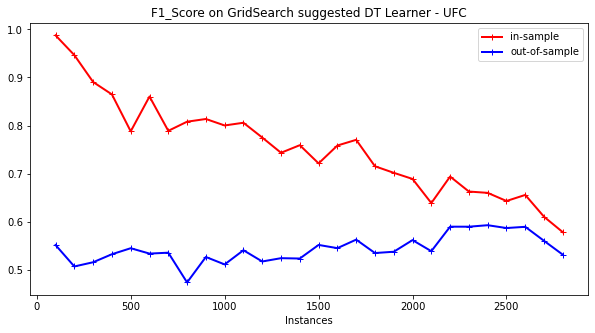

DecisionTreeClassifier(ccp_alpha=0.0031, criterion='entropy', max_depth=7) 0.5806244961256493


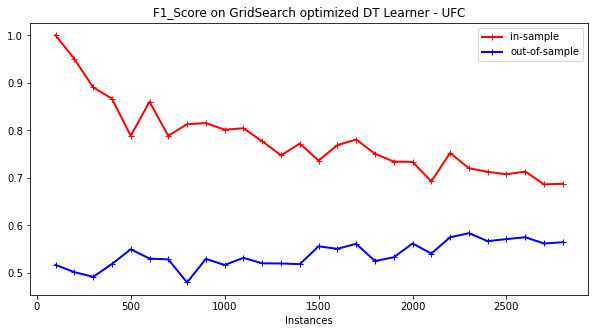

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   23.4s finished


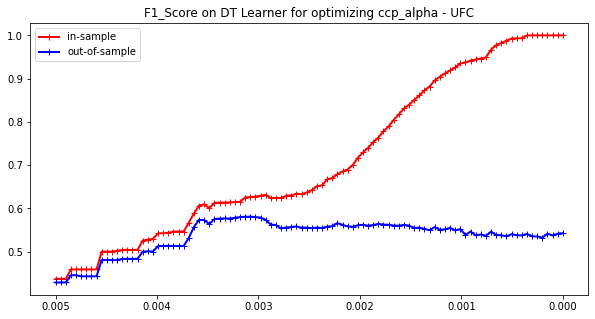

0.0030808080808080807


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.2s finished


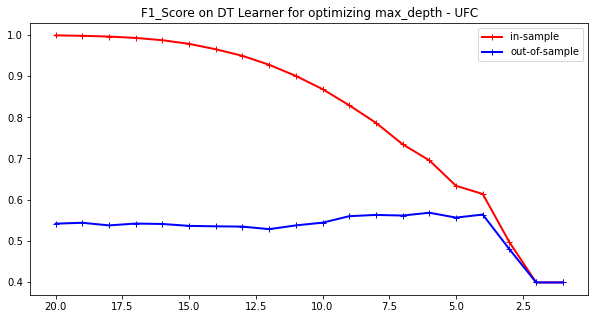

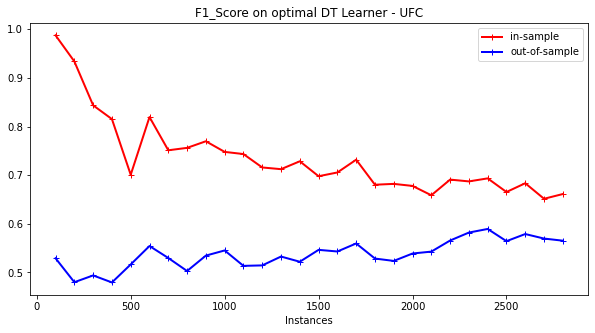

              precision    recall  f1-score   support

         0.0    0.47887   0.41975   0.44737       243
         1.0    0.72134   0.76681   0.74338       476

    accuracy                        0.64951       719
   macro avg    0.60011   0.59328   0.59537       719
weighted avg    0.63940   0.64951   0.64334       719



In [2]:
def define_decision_tree(input_train_set, output_train_set, complexity, split):
    DT_Learner = DecisionTreeClassifier(ccp_alpha=complexity, criterion=split)
    DT_Learner.fit(input_train_set, output_train_set)
    print(DT_Learner)
    return DT_Learner

def decision_tree_predictions(DT_Learner, input_train_set, output_train_set, mean):
    y_hat = DT_Learner.predict(input_train_set)
    percent_match = accuracy_score(output_train_set, y_hat)
    print(f1_score(output_train_set, y_hat, average = mean))
    return percent_match


def compute_score(input_train_set, output_train_set, DT_Learner, mean, title):
    result = evaluate_data(input_train_set, output_train_set, DT_Learner, f1_score, average=mean)
    graph_LC(result[0], result[1], result[2], title=title)
    

def run_gridsearch(values, input_train_set, output_train_set, cross_validation_splitter, weighting):
    grid_suggestion = GridSearchCV(DecisionTreeClassifier(), values, cv=cross_validation_splitter, scoring=weighting, n_jobs=-1)
    grid_suggestion.fit(input_train_set, output_train_set)
    print(grid_suggestion.best_estimator_, grid_suggestion.best_score_)
    
    return grid_suggestion
    
    
def run_validation_curve(input_train_set, output_train_set, hyperparameter_values, weighting, hyperparameter, title):
    result_train, result_test = validation_curve(
        DecisionTreeClassifier(), input_train_set, output_train_set, param_name = hyperparameter, 
        param_range=hyperparameter_values, scoring=weighting, verbose=1, cv=10, n_jobs=-1
    )
    print(result_train.mean(axis=1), result_test.mean(axis=1))
    
    graph_C(result_train.mean(axis=1), result_test.mean(axis=1), hyperparameter_values, title=title)
    
    return result_train, result_test

    
def ufc_dataset():
    target_feature = "Winner"
    complexity = 0.005
    mean = "macro"
    split = "entropy"
    weighting = "f1_macro"
    hyperparameter = "ccp_alpha"
    cross_validation_splitter = 10
    
    ufc_dataset = pd.read_csv("ufc_data.csv")
    
    ufc_dataset = preprocess_ufc_data(ufc_dataset)

    ufc_dataset = normalize_data(ufc_dataset)
    
    
    in_sample, out_of_sample = create_stratified_data(target_feature, ufc_dataset)

    output_train_set, input_train_set, output_test_set, input_test_set = prepare_data(in_sample, out_of_sample, target_feature)

    DT_Learner = define_decision_tree(input_train_set, output_train_set, complexity, split)
    print(DT_Learner)

    percent_match = decision_tree_predictions(DT_Learner, input_train_set, output_train_set, mean)

    result = cross_val_score(DT_Learner, input_train_set, output_train_set, scoring=weighting, cv=cross_validation_splitter)
    print(result, result.mean())

    compute_score(input_train_set, output_train_set, DT_Learner, mean, "F1_Score on Initial DT Learner - UFC")
    
    values = {
        'criterion': ['gini', 'entropy'],
        'ccp_alpha': [0.008, 0.007, 0.006, 0.005, 0.004, 0.005, 0.003, 0.002, 0.001],
        'splitter' : ['best', 'random'],
        'max_depth' : [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
    }

    grid_suggestion = run_gridsearch(values, input_train_set, output_train_set, cross_validation_splitter, weighting)

    compute_score(input_train_set, output_train_set, grid_suggestion.best_estimator_, mean, "F1_Score on GridSearch suggested DT Learner - UFC")

    values = {
        'criterion': ['entropy'],
        'ccp_alpha': [0.0035, 0.0034, 0.0033, 0.0032, 0.0031, 0.003, 0.0029, 0.0028, 0.0027, 0.0026],
        'splitter' : ['best', 'random'],
        'max_depth' : [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
    }
    
    grid_suggestion = run_gridsearch(values, input_train_set, output_train_set, cross_validation_splitter, weighting)

    compute_score(input_train_set, output_train_set, grid_suggestion.best_estimator_, mean, "F1_Score on GridSearch optimized DT Learner - UFC")


    hyperparameter_values = np.linspace(0.005, 0.000, 100)

    result_train, result_test = run_validation_curve(input_train_set, output_train_set, hyperparameter_values, weighting, hyperparameter, "F1_Score on DT Learner for optimizing ccp_alpha - UFC")

    j = result_test.mean(axis=1).argmax()
    optimal_complexity = hyperparameter_values[j]
    print(optimal_complexity)
    
    hyperparameter_values = np.linspace(1, 20, 20).astype(int)
    hyperparameter="max_depth"

    result_train, result_test = run_validation_curve(input_train_set, output_train_set, hyperparameter_values, weighting, hyperparameter, "F1_Score on DT Learner for optimizing max_depth - UFC")
    
    optimal_DT_Learner = DecisionTreeClassifier(ccp_alpha=optimal_complexity, criterion='entropy', max_depth=6)

    compute_score(input_train_set, output_train_set, optimal_DT_Learner, mean, "F1_Score on optimal DT Learner - UFC")
    
    optimal_DT_Learner.fit(input_train_set, output_train_set)
    test_y_hat = optimal_DT_Learner.predict(input_test_set)
    print(classification_report(output_test_set, test_y_hat,digits=5))
    
def wine_dataset():
    target_feature = "class"
    complexity = 0.003
    split = "entropy"
    mean = "weighted"
    weighting = "f1_weighted"
    hyperparameter = "ccp_alpha"
    cross_validation_splitter = 5

    np.random.seed(12)
    wine_dataset = pd.read_csv("wine_dataset.csv")
    
    target = wine_dataset[target_feature]
    wine_dataset = normalize_data(wine_dataset)
    wine_dataset[target_feature] = target
    

    in_sample, out_of_sample = create_stratified_data(target_feature, wine_dataset)

    output_train_set, input_train_set, output_test_set, input_test_set = prepare_data(in_sample, out_of_sample, target_feature)

    DT_Learner = define_decision_tree(input_train_set, output_train_set, complexity, split)

    percent_match = decision_tree_predictions(DT_Learner, input_train_set, output_train_set, mean)

    result = cross_val_score(DT_Learner, input_train_set, output_train_set, scoring=weighting, cv=10)
    print(result.mean())

    compute_score(input_train_set, output_train_set, DT_Learner, mean, "F1_Score on Initial DT Learner - Wine")
    
    values = {
        'criterion': ['gini', 'entropy'],
        'ccp_alpha': [0.010, 0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002, 0.001],
        'splitter' : ['best', 'random'],
        'max_depth' : [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
    }

    grid_suggestion = run_gridsearch(values, input_train_set, output_train_set, cross_validation_splitter, weighting)

    compute_score(input_train_set, output_train_set, grid_suggestion.best_estimator_, mean, "F1_Score on GridSearch suggested DT Learner - Wine")

    values = {
        'ccp_alpha': [0.0015, 0.0014, 0.0013, 0.0012, 0.0011, 0.001, 0.0009, 0.0008, 0.0007, 0.0006, 0.0005],
        'splitter' : ['best', 'random'],
        'max_depth' : [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
    }
    
    grid_suggestion = run_gridsearch(values, input_train_set, output_train_set, cross_validation_splitter, weighting)

    compute_score(input_train_set, output_train_set, grid_suggestion.best_estimator_, mean, "F1_Score on GridSearch optimized DT Learner - Wine")


    hyperparameter_values = np.linspace(0.0001, 0.002, 100)

    result_train, result_test = run_validation_curve(input_train_set, output_train_set, hyperparameter_values, weighting, hyperparameter, "F1_Score on DT Learner for optimizing ccp_alpha - Wine")


    j = result_test.mean(axis=1).argmax()
    optimal_complexity = hyperparameter_values[j]
    print(optimal_complexity)

    optimal_DT_Learner = DecisionTreeClassifier(ccp_alpha=optimal_complexity, max_depth=7)

    compute_score(input_train_set, output_train_set, optimal_DT_Learner, mean, "F1_Score on optimal DT Learner - Wine")

    optimal_DT_Learner.fit(input_train_set, output_train_set)
    test_y_hat = optimal_DT_Learner.predict(input_test_set)
    print(classification_report(output_test_set, test_y_hat, digits=5))
    print(f1_score(output_test_set, test_y_hat, average=mean))
    
    
if __name__ == "__main__":
    wine_dataset()
    ufc_dataset()